In [4]:
trainX = np.load('trainX.npy')
trainY = np.load('trainY.npy')
testX = np.load('testX.npy')
testY = np.load('testY.npy')

In [6]:
example_num, input_n, input_m, input_c = trainX.shape
output_num = len(trainY[0,:])
print(example_num, input_n, input_m, input_c, output_num)

511 160 160 3 23


In [7]:
import tensorflow as tf

print(tf.__version__)
session = tf.InteractiveSession()


1.8.0


In [12]:
x = tf.placeholder(tf.float32, shape=(None, input_n, input_m,input_c), name='x')
y = tf.placeholder(tf.float32, shape=(None, output_num), name='y')


conv1 = tf.layers.conv2d(inputs=x, filters=10, kernel_size=[7,7], padding='same', activation=tf.nn.relu,
                        kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1))
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2], strides=2, padding='same')

conv2 = tf.layers.conv2d(inputs=pool1, filters=15, kernel_size=[5,5], padding='same', activation=tf.nn.relu,
                        kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1))
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2], strides=2, padding='same')

conv3 = tf.layers.conv2d(inputs=pool2, filters=20, kernel_size=[5,5], padding='same', activation=tf.nn.relu,
                        kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1))

pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2,2], strides=2, padding='same')

flat = tf.contrib.layers.flatten(pool3)

dense1 = tf.layers.dense(inputs=flat, units=300, activation=tf.nn.relu)

keep_prob = tf.placeholder(tf.float32, shape=(), name='keep_prob')
dense1_dropout = tf.contrib.layers.dropout(dense1, keep_prob=keep_prob)

dense2 = tf.layers.dense(inputs=dense1_dropout, units=100, activation=tf.nn.relu)
dense2_dropout = tf.contrib.layers.dropout(dense2)

y_pred = tf.contrib.layers.fully_connected(dense2_dropout, output_num, activation_fn=None)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_pred)) # + tf.losses.get_regularization_loss()

lr = 0.01

#optimizer = tf.train.GradientDescentOptimizer(lr)
optimizer = tf.train.AdamOptimizer(lr, epsilon=1)
update = optimizer.minimize(cost)

pred = tf.cast(tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1)), tf.float32)
acc = tf.reduce_mean(pred)

In [15]:
from tqdm import tqdm_notebook
from copy import deepcopy
from random import shuffle
from random import choice, randint

batch_size = 16
epocs=2000
batch_num = int(example_num/batch_size)

session.run(tf.global_variables_initializer())
train_history = []
test_history = []

for epoch in tqdm_notebook(range(epocs)):
    err = 0
    acc_train_ = 0.0
    c = list(zip(deepcopy(trainX), deepcopy(trainY)))
    shuffle(c)
    trainX_sh, trainY_sh = list(zip(*c))
    for batch in range(batch_num): 
        batch_x = trainX_sh[batch*batch_size : batch*batch_size + batch_size]
        batch_y = trainY_sh[batch*batch_size : batch*batch_size + batch_size]
        
        new_batch_x = []
        for el in batch_x:
            augs = [iaa.Affine(rotate=(-10,10)),iaa.Fliplr(p=1, deterministic=1),iaa.Sharpen(alpha=1, lightness=1),
                    iaa.Affine(shear=-4), iaa.CoarseSaltAndPepper(0.01,1000),
                    iaa.Affine(translate_px={'x':randint(-10,10),'y':randint(-10,10)})] 
            #iaa.Affine(shear=5), iaa.blur.GaussianBlur(1.5)
            new_batch_x.append(choice(augs).augment_image(el))
        batch_x = np.array(new_batch_x)
        _, err_, acc_train = session.run([update, cost, acc], feed_dict={x:batch_x, y:batch_y, keep_prob:0.5})
        err += err_
        acc_train_ += acc_train
    err /= batch_num
    acc_train_ /= batch_num
    train_history.append(acc_train_)

    acc_test = session.run([acc], feed_dict={x:testX, y:testY, keep_prob:1})
    test_history.append(acc_test[0])
    print("epoch: %d error:%f, acc_train: %f, acc_test: %f" % (epoch, err, acc_train_,acc_test[0]), end='\n')
print("optimization done")

A Jupyter Widget

epoch: 0 error:5.256906, acc_train: 0.056452, acc_test: 0.065693
epoch: 1 error:3.263631, acc_train: 0.074597, acc_test: 0.094891
epoch: 2 error:3.164514, acc_train: 0.080645, acc_test: 0.102190
epoch: 3 error:3.138762, acc_train: 0.088710, acc_test: 0.102190
epoch: 4 error:3.143207, acc_train: 0.094758, acc_test: 0.102190
epoch: 5 error:3.137491, acc_train: 0.088710, acc_test: 0.102190
epoch: 6 error:3.127360, acc_train: 0.100806, acc_test: 0.102190
epoch: 7 error:3.120211, acc_train: 0.094758, acc_test: 0.102190
epoch: 8 error:3.115428, acc_train: 0.092742, acc_test: 0.102190
epoch: 9 error:3.113763, acc_train: 0.080645, acc_test: 0.102190
epoch: 10 error:3.101658, acc_train: 0.102823, acc_test: 0.102190
epoch: 11 error:3.098047, acc_train: 0.092742, acc_test: 0.094891
epoch: 12 error:3.090630, acc_train: 0.094758, acc_test: 0.109489
epoch: 13 error:3.086247, acc_train: 0.098790, acc_test: 0.102190
epoch: 14 error:3.091703, acc_train: 0.094758, acc_test: 0.102190
epoch: 15 error:3.08

epoch: 245 error:1.276826, acc_train: 0.604839, acc_test: 0.423358
epoch: 246 error:1.139739, acc_train: 0.657258, acc_test: 0.430657
epoch: 247 error:1.172612, acc_train: 0.671371, acc_test: 0.437956
epoch: 248 error:1.194538, acc_train: 0.629032, acc_test: 0.445255
epoch: 249 error:1.224309, acc_train: 0.608871, acc_test: 0.423358
epoch: 250 error:1.279205, acc_train: 0.631048, acc_test: 0.379562
epoch: 251 error:1.196063, acc_train: 0.633065, acc_test: 0.408759
epoch: 252 error:1.074817, acc_train: 0.665323, acc_test: 0.430657
epoch: 253 error:1.195685, acc_train: 0.641129, acc_test: 0.430657
epoch: 254 error:1.108753, acc_train: 0.675403, acc_test: 0.408759
epoch: 255 error:1.147229, acc_train: 0.629032, acc_test: 0.408759
epoch: 256 error:1.110664, acc_train: 0.675403, acc_test: 0.437956
epoch: 257 error:1.165430, acc_train: 0.661290, acc_test: 0.430657
epoch: 258 error:1.160807, acc_train: 0.663306, acc_test: 0.430657
epoch: 259 error:1.173687, acc_train: 0.651210, acc_test: 0.40

epoch: 489 error:0.767727, acc_train: 0.774194, acc_test: 0.489051
epoch: 490 error:0.706143, acc_train: 0.794355, acc_test: 0.489051
epoch: 491 error:0.717681, acc_train: 0.784274, acc_test: 0.489051
epoch: 492 error:0.855536, acc_train: 0.758065, acc_test: 0.489051
epoch: 493 error:0.751724, acc_train: 0.774194, acc_test: 0.503650
epoch: 494 error:0.768522, acc_train: 0.758065, acc_test: 0.496350
epoch: 495 error:0.729655, acc_train: 0.778226, acc_test: 0.503650
epoch: 496 error:0.821943, acc_train: 0.747984, acc_test: 0.525547
epoch: 497 error:0.805961, acc_train: 0.770161, acc_test: 0.510949
epoch: 498 error:0.645603, acc_train: 0.800403, acc_test: 0.510949
epoch: 499 error:0.796840, acc_train: 0.774194, acc_test: 0.481752
epoch: 500 error:0.878276, acc_train: 0.747984, acc_test: 0.532847
epoch: 501 error:0.782977, acc_train: 0.768145, acc_test: 0.518248
epoch: 502 error:0.672151, acc_train: 0.794355, acc_test: 0.496350
epoch: 503 error:0.782804, acc_train: 0.780242, acc_test: 0.50

epoch: 733 error:0.678017, acc_train: 0.816532, acc_test: 0.547445
epoch: 734 error:0.640313, acc_train: 0.818548, acc_test: 0.510949
epoch: 735 error:0.662472, acc_train: 0.810484, acc_test: 0.481752
epoch: 736 error:0.666213, acc_train: 0.808468, acc_test: 0.510949
epoch: 737 error:0.655786, acc_train: 0.802419, acc_test: 0.518248
epoch: 738 error:0.645575, acc_train: 0.808468, acc_test: 0.540146
epoch: 739 error:0.601103, acc_train: 0.828629, acc_test: 0.525547
epoch: 740 error:0.679791, acc_train: 0.786290, acc_test: 0.525547
epoch: 741 error:0.675630, acc_train: 0.802419, acc_test: 0.547445
epoch: 742 error:0.667336, acc_train: 0.802419, acc_test: 0.532847
epoch: 743 error:0.688458, acc_train: 0.804435, acc_test: 0.518248
epoch: 744 error:0.637687, acc_train: 0.802419, acc_test: 0.576642
epoch: 745 error:0.617101, acc_train: 0.812500, acc_test: 0.503650
epoch: 746 error:0.549794, acc_train: 0.838710, acc_test: 0.518248
epoch: 747 error:0.667883, acc_train: 0.800403, acc_test: 0.56

epoch: 977 error:0.709923, acc_train: 0.788306, acc_test: 0.525547
epoch: 978 error:0.654927, acc_train: 0.808468, acc_test: 0.481752
epoch: 979 error:0.690416, acc_train: 0.794355, acc_test: 0.510949
epoch: 980 error:0.547282, acc_train: 0.842742, acc_test: 0.503650
epoch: 981 error:0.575293, acc_train: 0.826613, acc_test: 0.576642
epoch: 982 error:0.736725, acc_train: 0.776210, acc_test: 0.532847
epoch: 983 error:0.641634, acc_train: 0.808468, acc_test: 0.532847
epoch: 984 error:0.637805, acc_train: 0.820565, acc_test: 0.503650
epoch: 985 error:0.606253, acc_train: 0.812500, acc_test: 0.481752
epoch: 986 error:0.677543, acc_train: 0.804435, acc_test: 0.489051
epoch: 987 error:0.619189, acc_train: 0.830645, acc_test: 0.503650
epoch: 988 error:0.612057, acc_train: 0.814516, acc_test: 0.496350
epoch: 989 error:0.738017, acc_train: 0.796371, acc_test: 0.525547
epoch: 990 error:0.690323, acc_train: 0.796371, acc_test: 0.518248
epoch: 991 error:0.609878, acc_train: 0.812500, acc_test: 0.51

epoch: 1217 error:0.629646, acc_train: 0.818548, acc_test: 0.562044
epoch: 1218 error:0.610881, acc_train: 0.830645, acc_test: 0.532847
epoch: 1219 error:0.598582, acc_train: 0.824597, acc_test: 0.547445
epoch: 1220 error:0.720689, acc_train: 0.800403, acc_test: 0.540146
epoch: 1221 error:0.522442, acc_train: 0.842742, acc_test: 0.518248
epoch: 1222 error:0.622529, acc_train: 0.814516, acc_test: 0.540146
epoch: 1223 error:0.485325, acc_train: 0.864919, acc_test: 0.554745
epoch: 1224 error:0.602245, acc_train: 0.812500, acc_test: 0.576642
epoch: 1225 error:0.441263, acc_train: 0.870968, acc_test: 0.518248
epoch: 1226 error:0.652960, acc_train: 0.814516, acc_test: 0.510949
epoch: 1227 error:0.671131, acc_train: 0.808468, acc_test: 0.525547
epoch: 1228 error:0.571078, acc_train: 0.824597, acc_test: 0.532847
epoch: 1229 error:0.465190, acc_train: 0.864919, acc_test: 0.503650
epoch: 1230 error:0.686135, acc_train: 0.804435, acc_test: 0.532847
epoch: 1231 error:0.629046, acc_train: 0.806452,

epoch: 1457 error:0.447557, acc_train: 0.860887, acc_test: 0.547445
epoch: 1458 error:0.642938, acc_train: 0.804435, acc_test: 0.510949
epoch: 1459 error:0.640618, acc_train: 0.816532, acc_test: 0.532847
epoch: 1460 error:0.596267, acc_train: 0.834677, acc_test: 0.474453
epoch: 1461 error:0.473786, acc_train: 0.856855, acc_test: 0.496350
epoch: 1462 error:0.630912, acc_train: 0.818548, acc_test: 0.510949
epoch: 1463 error:0.473694, acc_train: 0.864919, acc_test: 0.481752
epoch: 1464 error:0.611638, acc_train: 0.826613, acc_test: 0.496350
epoch: 1465 error:0.615928, acc_train: 0.830645, acc_test: 0.496350
epoch: 1466 error:0.611936, acc_train: 0.818548, acc_test: 0.474453
epoch: 1467 error:0.573559, acc_train: 0.836694, acc_test: 0.525547
epoch: 1468 error:0.605330, acc_train: 0.822581, acc_test: 0.540146
epoch: 1469 error:0.652134, acc_train: 0.804435, acc_test: 0.467153
epoch: 1470 error:0.600918, acc_train: 0.818548, acc_test: 0.503650
epoch: 1471 error:0.649144, acc_train: 0.810484,

epoch: 1697 error:0.575092, acc_train: 0.834677, acc_test: 0.510949
epoch: 1698 error:0.502230, acc_train: 0.860887, acc_test: 0.525547
epoch: 1699 error:0.563397, acc_train: 0.838710, acc_test: 0.576642
epoch: 1700 error:0.429950, acc_train: 0.879032, acc_test: 0.583942
epoch: 1701 error:0.513186, acc_train: 0.858871, acc_test: 0.540146
epoch: 1702 error:0.565996, acc_train: 0.828629, acc_test: 0.518248
epoch: 1703 error:0.607439, acc_train: 0.824597, acc_test: 0.532847
epoch: 1704 error:0.610849, acc_train: 0.820565, acc_test: 0.554745
epoch: 1705 error:0.605497, acc_train: 0.818548, acc_test: 0.481752
epoch: 1706 error:0.691707, acc_train: 0.796371, acc_test: 0.496350
epoch: 1707 error:0.644169, acc_train: 0.804435, acc_test: 0.547445
epoch: 1708 error:0.501398, acc_train: 0.860887, acc_test: 0.532847
epoch: 1709 error:0.632686, acc_train: 0.812500, acc_test: 0.496350
epoch: 1710 error:0.593197, acc_train: 0.826613, acc_test: 0.496350
epoch: 1711 error:0.587916, acc_train: 0.824597,

epoch: 1937 error:0.565259, acc_train: 0.838710, acc_test: 0.489051
epoch: 1938 error:0.543813, acc_train: 0.844758, acc_test: 0.532847
epoch: 1939 error:0.585481, acc_train: 0.818548, acc_test: 0.518248
epoch: 1940 error:0.597345, acc_train: 0.824597, acc_test: 0.525547
epoch: 1941 error:0.513584, acc_train: 0.838710, acc_test: 0.518248
epoch: 1942 error:0.623734, acc_train: 0.810484, acc_test: 0.547445
epoch: 1943 error:0.628039, acc_train: 0.818548, acc_test: 0.532847
epoch: 1944 error:0.516823, acc_train: 0.846774, acc_test: 0.510949
epoch: 1945 error:0.570584, acc_train: 0.834677, acc_test: 0.510949
epoch: 1946 error:0.480390, acc_train: 0.864919, acc_test: 0.525547
epoch: 1947 error:0.562644, acc_train: 0.836694, acc_test: 0.554745
epoch: 1948 error:0.557599, acc_train: 0.838710, acc_test: 0.518248
epoch: 1949 error:0.534629, acc_train: 0.836694, acc_test: 0.510949
epoch: 1950 error:0.523086, acc_train: 0.838710, acc_test: 0.532847
epoch: 1951 error:0.479345, acc_train: 0.856855,

epoch: 2177 error:0.542672, acc_train: 0.848790, acc_test: 0.547445
epoch: 2178 error:0.461169, acc_train: 0.879032, acc_test: 0.532847
epoch: 2179 error:0.565849, acc_train: 0.840726, acc_test: 0.547445
epoch: 2180 error:0.643617, acc_train: 0.822581, acc_test: 0.525547
epoch: 2181 error:0.590181, acc_train: 0.838710, acc_test: 0.540146
epoch: 2182 error:0.529626, acc_train: 0.848790, acc_test: 0.518248
epoch: 2183 error:0.632743, acc_train: 0.816532, acc_test: 0.518248
epoch: 2184 error:0.716081, acc_train: 0.786290, acc_test: 0.518248
epoch: 2185 error:0.589045, acc_train: 0.828629, acc_test: 0.569343
epoch: 2186 error:0.586229, acc_train: 0.826613, acc_test: 0.562044
epoch: 2187 error:0.495165, acc_train: 0.854839, acc_test: 0.562044
epoch: 2188 error:0.574027, acc_train: 0.846774, acc_test: 0.554745
epoch: 2189 error:0.574931, acc_train: 0.822581, acc_test: 0.496350
epoch: 2190 error:0.546956, acc_train: 0.858871, acc_test: 0.547445
epoch: 2191 error:0.529165, acc_train: 0.838710,

epoch: 2417 error:0.562960, acc_train: 0.846774, acc_test: 0.510949
epoch: 2418 error:0.522977, acc_train: 0.844758, acc_test: 0.481752
epoch: 2419 error:0.525677, acc_train: 0.854839, acc_test: 0.518248
epoch: 2420 error:0.543873, acc_train: 0.842742, acc_test: 0.489051
epoch: 2421 error:0.464804, acc_train: 0.866935, acc_test: 0.481752
epoch: 2422 error:0.578785, acc_train: 0.826613, acc_test: 0.496350
epoch: 2423 error:0.446789, acc_train: 0.877016, acc_test: 0.474453
epoch: 2424 error:0.482478, acc_train: 0.860887, acc_test: 0.525547
epoch: 2425 error:0.566755, acc_train: 0.840726, acc_test: 0.510949
epoch: 2426 error:0.588791, acc_train: 0.830645, acc_test: 0.489051
epoch: 2427 error:0.492764, acc_train: 0.854839, acc_test: 0.496350
epoch: 2428 error:0.533594, acc_train: 0.848790, acc_test: 0.474453
epoch: 2429 error:0.631886, acc_train: 0.806452, acc_test: 0.503650
epoch: 2430 error:0.582153, acc_train: 0.826613, acc_test: 0.481752
epoch: 2431 error:0.541223, acc_train: 0.848790,

epoch: 2657 error:0.405500, acc_train: 0.883065, acc_test: 0.474453
epoch: 2658 error:0.265543, acc_train: 0.915323, acc_test: 0.503650
epoch: 2659 error:0.298136, acc_train: 0.929435, acc_test: 0.489051
epoch: 2660 error:0.239430, acc_train: 0.931452, acc_test: 0.532847
epoch: 2661 error:0.263560, acc_train: 0.913306, acc_test: 0.489051
epoch: 2662 error:0.311421, acc_train: 0.919355, acc_test: 0.547445
epoch: 2663 error:0.302306, acc_train: 0.917339, acc_test: 0.503650
epoch: 2664 error:0.321471, acc_train: 0.909274, acc_test: 0.554745
epoch: 2665 error:0.240915, acc_train: 0.931452, acc_test: 0.489051
epoch: 2666 error:0.286534, acc_train: 0.913306, acc_test: 0.503650
epoch: 2667 error:0.264349, acc_train: 0.943548, acc_test: 0.503650
epoch: 2668 error:0.251614, acc_train: 0.921371, acc_test: 0.496350
epoch: 2669 error:0.317949, acc_train: 0.895161, acc_test: 0.489051
epoch: 2670 error:0.297554, acc_train: 0.931452, acc_test: 0.532847
epoch: 2671 error:0.237799, acc_train: 0.937500,

epoch: 2897 error:0.137358, acc_train: 0.965726, acc_test: 0.532847
epoch: 2898 error:0.146696, acc_train: 0.955645, acc_test: 0.510949
epoch: 2899 error:0.213841, acc_train: 0.947581, acc_test: 0.518248
epoch: 2900 error:0.151414, acc_train: 0.953629, acc_test: 0.562044
epoch: 2901 error:0.159198, acc_train: 0.951613, acc_test: 0.496350
epoch: 2902 error:0.143732, acc_train: 0.971774, acc_test: 0.510949
epoch: 2903 error:0.100359, acc_train: 0.973790, acc_test: 0.496350
epoch: 2904 error:0.106018, acc_train: 0.971774, acc_test: 0.518248
epoch: 2905 error:0.214300, acc_train: 0.935484, acc_test: 0.518248
epoch: 2906 error:0.212609, acc_train: 0.935484, acc_test: 0.503650
epoch: 2907 error:0.317155, acc_train: 0.923387, acc_test: 0.496350
epoch: 2908 error:0.205701, acc_train: 0.943548, acc_test: 0.518248
epoch: 2909 error:0.163868, acc_train: 0.963710, acc_test: 0.496350
epoch: 2910 error:0.217498, acc_train: 0.927419, acc_test: 0.467153
epoch: 2911 error:0.129980, acc_train: 0.955645,

epoch: 3137 error:0.085717, acc_train: 0.969758, acc_test: 0.518248
epoch: 3138 error:0.086714, acc_train: 0.979839, acc_test: 0.503650
epoch: 3139 error:0.113574, acc_train: 0.965726, acc_test: 0.496350
epoch: 3140 error:0.101697, acc_train: 0.971774, acc_test: 0.532847
epoch: 3141 error:0.148604, acc_train: 0.959677, acc_test: 0.489051
epoch: 3142 error:0.145456, acc_train: 0.957661, acc_test: 0.532847
epoch: 3143 error:0.123050, acc_train: 0.961694, acc_test: 0.496350
epoch: 3144 error:0.108229, acc_train: 0.967742, acc_test: 0.510949
epoch: 3145 error:0.090236, acc_train: 0.973790, acc_test: 0.525547
epoch: 3146 error:0.099301, acc_train: 0.979839, acc_test: 0.525547
epoch: 3147 error:0.090504, acc_train: 0.967742, acc_test: 0.489051
epoch: 3148 error:0.165500, acc_train: 0.953629, acc_test: 0.518248
epoch: 3149 error:0.134817, acc_train: 0.963710, acc_test: 0.540146
epoch: 3150 error:0.096638, acc_train: 0.971774, acc_test: 0.540146
epoch: 3151 error:0.154702, acc_train: 0.951613,

KeyboardInterrupt: 

(took too long, so i breaked it) <br>
and continued for another 100 of iterations

In [18]:
batch_size = 16
epocs=100
batch_num = int(example_num/batch_size)

for epoch in tqdm_notebook(range(epocs)):
    err = 0
    acc_train_ = 0.0
    c = list(zip(deepcopy(trainX), deepcopy(trainY)))
    shuffle(c)
    trainX_sh, trainY_sh = list(zip(*c))
    for batch in range(batch_num):
        batch_x = trainX_sh[batch*batch_size : batch*batch_size + batch_size]
        batch_y = trainY_sh[batch*batch_size : batch*batch_size + batch_size]
        
        new_batch_x = []
        from random import choice, randint
        for el in batch_x:
            augs = [iaa.Affine(rotate=(-10,10)),iaa.Fliplr(p=1, deterministic=1),iaa.Sharpen(alpha=1, lightness=1),
                    iaa.Affine(shear=-4), iaa.CoarseSaltAndPepper(0.01,1000),
                    iaa.Affine(translate_px={'x':randint(-10,10),'y':randint(-10,10)})] 
            #iaa.Affine(shear=5), iaa.blur.GaussianBlur(1.5)
            new_batch_x.append(choice(augs).augment_image(el))
        batch_x = np.array(new_batch_x)

        _, err_, acc_train = session.run([update, cost, acc], feed_dict={x:batch_x, y:batch_y, keep_prob:0.5})
        err += err_
        acc_train_ += acc_train
    err /= batch_num
    acc_train_ /= batch_num
    train_history.append(acc_train_)
    
    acc_test = session.run([acc], feed_dict={x:testX, y:testY, keep_prob:1})
    test_history.append(acc_test[0])
    print("epoch: %d error:%f, acc_train: %f, acc_test: %f" % (epoch, err, acc_train_,acc_test[0]), end='\n')
print("optimization done")

A Jupyter Widget

Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\ProgramData\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch: 0 error:0.126834, acc_train: 0.969758, acc_test: 0.532847
epoch: 1 error:0.087727, acc_train: 0.975806, acc_test: 0.525547
epoch: 2 error:0.085286, acc_train: 0.971774, acc_test: 0.496350
epoch: 3 error:0.121500, acc_train: 0.969758, acc_test: 0.569343
epoch: 4 error:0.161817, acc_train: 0.965726, acc_test: 0.532847
epoch: 5 error:0.116957, acc_train: 0.973790, acc_test: 0.540146
epoch: 6 error:0.067378, acc_train: 0.981855, acc_test: 0.503650
epoch: 7 error:0.083696, acc_train: 0.979839, acc_test: 0.576642
epoch: 8 error:0.068171, acc_train: 0.973790, acc_test: 0.518248
epoch: 9 error:0.122978, acc_train: 0.965726, acc_test: 0.562044
epoch: 10 error:0.092107, acc_train: 0.969758, acc_test: 0.525547
epoch: 11 error:0.102242, acc_train: 0.967742, acc_test: 0.547445
epoch: 12 error:0.125857, acc_train: 0.971774, acc_test: 0.503650
epoch: 13 error:0.119458, acc_train: 0.961694, acc_test: 0.554745
epoch: 14 error:0.143539, acc_train: 0.963710, acc_test: 0.532847
epoch: 15 error:0.16

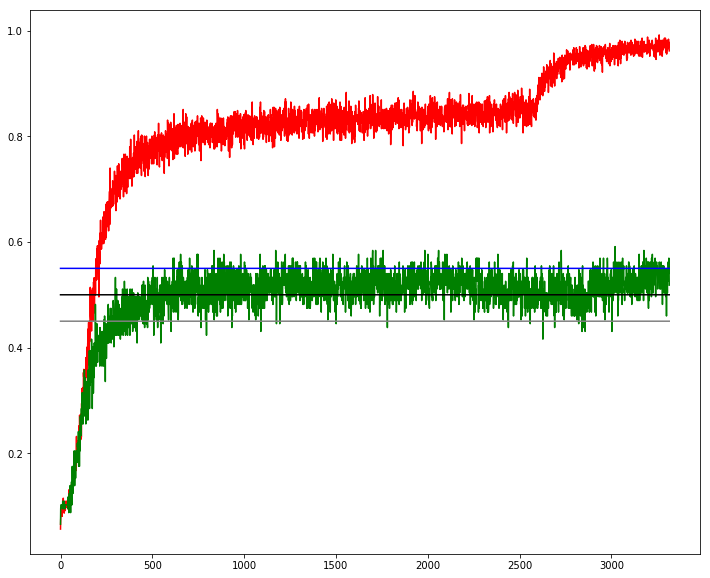

In [19]:
plt.figure(figsize=(12,10))
plt.plot(list(range(len(train_history))), train_history, color='r')
plt.plot(list(range(len(test_history))), test_history, color='g')
plt.plot(list(range(len(train_history))), [0.5]*len(train_history), 'black')
plt.plot(list(range(len(train_history))), [0.55]*len(train_history), 'blue')
plt.plot(list(range(len(train_history))), [0.45]*len(train_history), 'grey')
plt.show()

In [25]:
acc_test = session.run([acc], feed_dict={x:testX, y:testY, keep_prob:1})

In [26]:
print(acc_test[0])

0.540146
